In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Preliminaries
Just try out the search_ddg_images and get used to importing all the things we need

In [2]:
!pip install -Uqq fastbook

In [3]:
# Import libraries we'll need

# for search_images_ddg, download_url we need fastbook
import fastbook

# Not sure why we need widgets
from fastai.vision.widgets import *

# For Path, we need pathlib; for Image, we need PIL
import pathlib
import PIL

# For plot_top_losses we need matplotlib
import matplotlib.pyplot as plt

In [4]:
ims = fastbook.search_images_ddg('zinedine zidane')

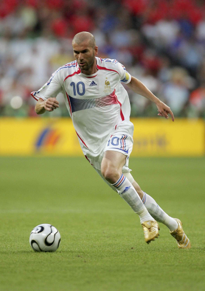

In [5]:
# Let's take a look at one of them
dest = pathlib.Path("/kaggle/working/zinedine_zidane.jpg")
fastbook.download_url(ims[0], dest, show_progress=True)
im = PIL.Image.open(dest)
im.to_thumb(291, 291)

# Build a Zidane/Mbappe/Scholes Classifier

## Get the data, remove any bad downloads

In [6]:
players = ["zinedine zidane", "paul scholes", "kylian mbappe"]
footballers_path = pathlib.Path("/kaggle/working/footballers")

In [10]:
if not footballers_path.exists():
    footballers_path.mkdir()

In [11]:
for player in players:
    dest = footballers_path/player
    print(dest)
    dest.mkdir(exist_ok=True)
    results = fastbook.search_images_ddg(f'{player}')
    fastbook.download_images(dest, urls=results)

/kaggle/working/footballers/zinedine zidane
/kaggle/working/footballers/paul scholes
/kaggle/working/footballers/kylian mbappe


In [12]:
fns = fastbook.get_image_files(footballers_path)

In [13]:
failed = fastbook.verify_images(fns)

In [14]:
len(failed)

35

In [15]:
failed.map(pathlib.Path.unlink)

(#35) [None,None,None,None,None,None,None,None,None,None...]

## Build a fastai DataBlock and augment the data

In [16]:
players_data_block = fastbook.DataBlock(
    blocks=(fastbook.ImageBlock, fastbook.CategoryBlock),
    get_items=fastbook.get_image_files,
    splitter=fastbook.RandomSplitter(
        valid_pct=0.2,
        seed=42
    ),
    get_y=fastbook.parent_label,
    item_tfms=fastbook.Resize(128)
)

In [17]:
players_data_loader = players_data_block.dataloaders(footballers_path)

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:980: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


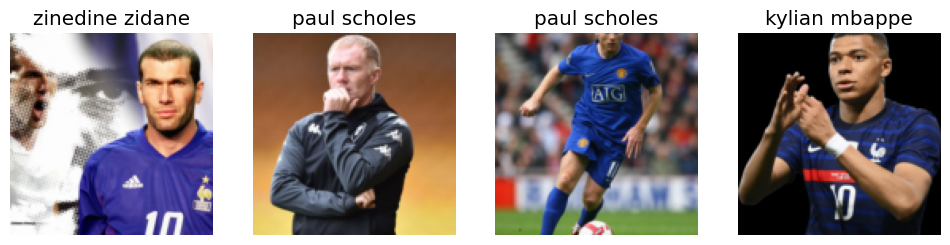

In [18]:
players_data_loader.valid.show_batch(max_n=4, nrows=1)

In [19]:
# Augment the data; make a new data block
players_data_block = players_data_block.new(
    item_tfms=fastbook.Resize(128),
    batch_tfms=fastbook.aug_transforms(
        mult=2.0
    )
)

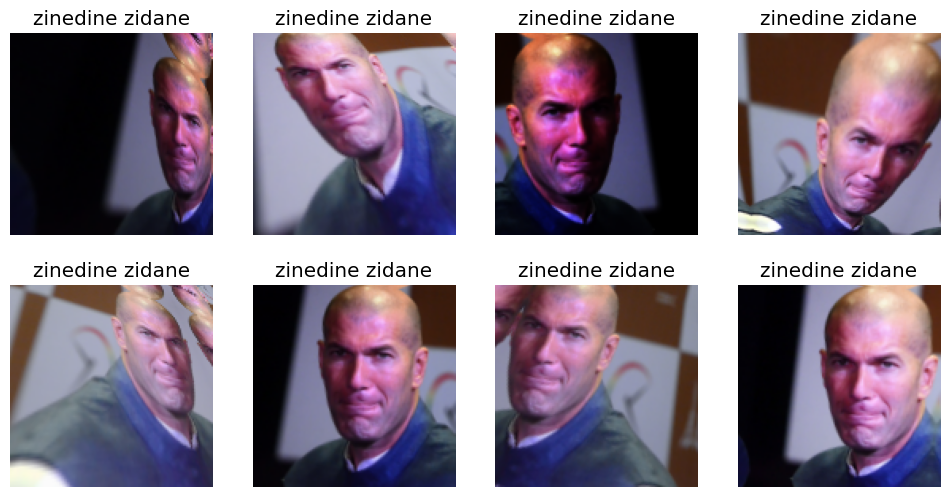

In [20]:
players_data_loader = players_data_block.dataloaders(footballers_path)
players_data_loader.train.show_batch(
    max_n=8,
    nrows=2,
    unique=True
)

# Train the model

In [21]:
players_data_loader = players_data_block.new(
    item_tfms=fastbook.RandomResizedCrop(
        size=224,
        min_scale=0.5
    ),
    batch_tfms=fastbook.aug_transforms()
)
players_data_loader = players_data_block.dataloaders(footballers_path)

In [22]:
learn = fastbook.vision_learner(
    dls=players_data_loader,
    arch=fastbook.models.resnet34,
    metrics=fastbook.error_rate
)
learn.fine_tune(8)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.780765,1.266415,0.413462,00:40


epoch,train_loss,valid_loss,error_rate,time
0,0.887967,0.661447,0.221154,00:36
1,0.781595,0.514865,0.211538,00:36
2,0.645444,0.295597,0.086538,00:36
3,0.512578,0.289903,0.096154,00:36
4,0.430435,0.263467,0.086538,00:38
5,0.366681,0.257623,0.076923,00:37
6,0.314522,0.259224,0.076923,00:36
7,0.268705,0.257074,0.086538,00:31


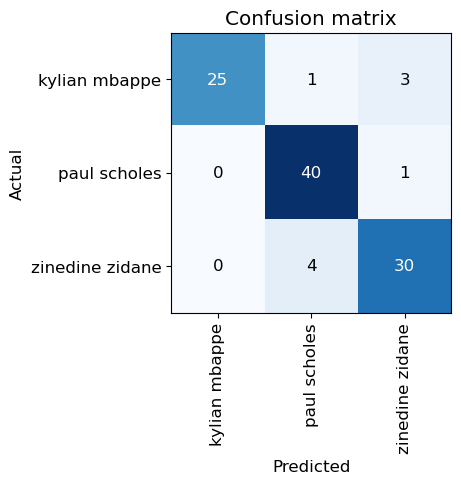

In [23]:
interp = fastbook.ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

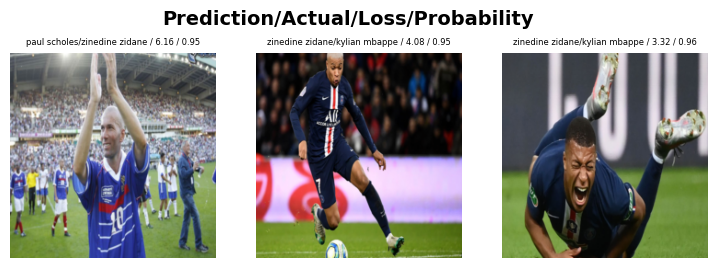

In [24]:
plt.rcParams.update({'font.size': 5})
interp.plot_top_losses(3, nrows=1)

In [25]:
# See what images were hard for the network to classify
cleaner = ImageClassifierCleaner(learn)
cleaner

In [31]:
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

In [32]:
for idx, cat in cleaner.change():
    fastbook.shutil.move(
        str(cleaner.fns[idx]),
        path/cat
    )

In [28]:
learn.export(fname="zidane_scholes_mbappe_resnet34.pkl")

In [29]:
learn.predict("/kaggle/working/zinedine_zidane.jpg")

('zinedine zidane',
 TensorBase(2),
 TensorBase([6.8216e-04, 3.8975e-04, 9.9893e-01]))

In [30]:
learn.dls.vocab

['kylian mbappe', 'paul scholes', 'zinedine zidane']